In [1]:
import multiprocessing
import uuid
import os

if not os.path.exists('out'):
    os.makedirs('out')
if not os.path.exists('results'):
    os.makedirs('results')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.cm import ScalarMappable
mpl.rcParams["text.usetex"] = True

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction

In [2]:
target_name = 'SEIZ_updated'
threads_per_run = multiprocessing.cpu_count()
init_exposures = 100
epsilon = 2
batch_size = 10

parameter_space = ParameterSpace([ContinuousParameter('p', 0, 1),
                                  ContinuousParameter('l', 0, 1),
                                  DiscreteParameter('prop_init_skeptics', np.arange(1, init_exposures, 1, dtype=np.int_))])

In [3]:
def run_job(p, l, init_skeptics, init_adopters):
    with open(f'{target_name}_editable.fred', 'r') as file:
        filedata = file.read()

    vars = {
        'p': p, 
        'l': l, 
        'epsilon': epsilon, 
        'init_skeptic': int(init_skeptics), 
        'init_adopt': int(init_adopters)
    }

    run_uuid = uuid.uuid4()
    var_str = ', '.join(map(lambda item: f'{item[0]}={item[1]}', vars.items()))
    print(run_uuid, var_str)

    with open(f'out/{target_name}_{run_uuid}_out.fred', 'w') as file:
        file.write(filedata.format(**vars))
        
    !fred_job -p out/{target_name}_{run_uuid}_out.fred -k {target_name}_{run_uuid}_run -t {threads_per_run}
    !fred_csv -k {target_name}_{run_uuid}_run > results/{target_name}_{run_uuid}_run.csv

    with open(f'results/{target_name}_{run_uuid}_run.csv', 'r') as file:
        lines = file.readlines()

    with open(f'results/{target_name}_{run_uuid}_run.csv', 'w') as file:
        lines[0] = var_str+'\n'
        file.writelines(lines)

    return pd.read_csv(f'results/{target_name}_{run_uuid}_run.csv', header=2)

In [4]:
def sample(X, clear_results=False):
    X = np.array(X)
    
    if X.ndim < 2:
        X = np.expand_dims(X, 0)
    elif X.ndim > 2:
        raise Exception(f'X has too many dimensions (ndim={X.ndim}, must be 1 or 2)')
    if X.shape[-1] != parameter_space.dimensionality:
        raise Exception(f'X has the wrong number of variables (variables={X.shape[-1]}, must be {parameter_space.dimensionality})')

    X = np.append(X, np.expand_dims(init_exposures-X[:,-1], axis=1), axis=1)  # create and add init_adopters variable

    if clear_results:
        !yes | fred_clear_all_results
    
    Y = []

    with multiprocessing.Pool() as pool:
        for data in pool.starmap(run_job, X):
            S_count = data['ADOPT.totS'].iat[0]
            Y.append([(-data['ADOPT.S'].diff()).max() / S_count])
        
    return np.vstack(Y)

In [5]:
design = LatinDesign(parameter_space)
num_data_points = batch_size
X = design.get_samples(num_data_points)

In [6]:
X

array([[3.5e-01, 4.5e-01, 4.5e+01],
       [1.5e-01, 6.5e-01, 2.5e+01],
       [2.5e-01, 7.5e-01, 6.0e+00],
       [6.5e-01, 2.5e-01, 8.4e+01],
       [5.5e-01, 8.5e-01, 9.4e+01],
       [9.5e-01, 1.5e-01, 3.5e+01],
       [7.5e-01, 3.5e-01, 6.5e+01],
       [5.0e-02, 5.5e-01, 5.5e+01],
       [4.5e-01, 5.0e-02, 7.4e+01],
       [8.5e-01, 9.5e-01, 1.6e+01]])

In [7]:
Y = sample(X, clear_results=True)

You are about to delete /home/nyoma/FRED/RESULTS. This cannot be undone.
Proceed? yes/no [no]
/home/nyoma/FRED/RESULTS deleted
yes: standard output: Broken pipe
06c7c447-4d7c-4241-abbe-e07f69425ddff542e294-769d-4c0c-931a-86a66cfbb2d7a4053883-bb2f-4b67-b35a-1e851baac09b6a342d2f-6f18-4a03-a541-b1d370b5af0972f7f4d1-5292-42c3-9be9-bef28b6ca10aaa25d532-c283-4e0e-8620-d7ba173c32db2a206190-323b-4501-8281-16aa9b69bcf3815cb5e0-201c-47cf-b12e-74f0bb92cdbe396f51e8-c833-40df-a00f-87860dc4ac9b  a909fef0-0c03-45ff-bd9b-d800c61946a4      p=0.55, l=0.8500000000000001, epsilon=2, init_skeptic=94, init_adopt=6 p=0.35000000000000003, l=0.45, epsilon=2, init_skeptic=45, init_adopt=55 p=0.6500000000000001, l=0.25, epsilon=2, init_skeptic=84, init_adopt=16p=0.45, l=0.05, epsilon=2, init_skeptic=74, init_adopt=26p=0.05, l=0.55, epsilon=2, init_skeptic=55, init_adopt=45p=0.25, l=0.75, epsilon=2, init_skeptic=6, init_adopt=94p=0.15000000000000002, l=0.6500000000000001, epsilon=2, init_skeptic=25, init_adopt=75

In [8]:
Y

array([[0.06096915],
       [0.04728805],
       [0.05044353],
       [0.06666225],
       [0.02431705],
       [0.07348074],
       [0.0699722 ],
       [0.04903129],
       [0.05827706],
       [0.04424291]])

In [9]:
model_gpy = GPRegression(X,Y)
model_emukit = GPyModelWrapper(model_gpy)

In [10]:
model_variance = ModelVariance(model=model_emukit)
expdesign_loop = ExperimentalDesignLoop(model=model_emukit,
                                        space=parameter_space,
                                        acquisition=model_variance,
                                        batch_size=batch_size)

max_iterations = 25
expdesign_loop.run_loop(sample, max_iterations)

c686fc3a-4d71-4613-8dfb-18d6c4fd71ea5a6cb5f8-484f-4a62-a3a4-061aad322a31b9208c57-a35b-4784-a400-3641760f494025f70d5a-a6ab-4404-93bc-b9c50827cbbc4769fb2b-ea56-4d82-a2c5-0e2426c1d8782455e0b6-9015-4a65-95ec-3a1c25c6b4cc05da1455-a3c1-4408-b588-a59afb70dc41c834f113-61aa-4755-91fa-2f4b8229a17de63ecbbe-c5fd-4872-892e-1b6b35035804807bd90a-0600-4f52-b2d4-1d62615f0c70         p=0.9837998556216496, l=0.1806670653044372, epsilon=2, init_skeptic=1, init_adopt=99 p=0.1293798234624618, l=0.15226883824378357, epsilon=2, init_skeptic=99, init_adopt=1p=0.09357749329838516, l=0.942525484051096, epsilon=2, init_skeptic=79, init_adopt=21p=0.9383680294525663, l=0.936556283093092, epsilon=2, init_skeptic=50, init_adopt=50p=0.2180303054968905, l=0.017912956803654678, epsilon=2, init_skeptic=11, init_adopt=89p=0.03071423150298791, l=0.2685715363612584, epsilon=2, init_skeptic=30, init_adopt=70p=0.0222953715262576, l=0.9449869232816196, epsilon=2, init_skeptic=60, init_adopt=40p=0.0839378375015869, l=0.86656497

 /home/nyoma/.local/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/nyoma/.local/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


4df1c06c-553d-470b-9e2e-c5ec80e8e4252c3aca47-0b0a-499c-99d3-024a4f1d36123b5f3d6a-fd12-4e35-9643-24b0f588438159b1aaa3-7827-4cee-b7b1-c463dcfc45e6463d4cf5-1554-40f1-9e84-90fef70fe56a352e1614-6e45-4096-86b5-d843ccb0521bc1b7fadc-56d4-460b-bc0e-9575c3ca6c996a2675d1-6cdf-4c95-927d-689947d3cbf78065ef35-5c2d-47ff-97f8-e1b548b2466ae9997f2a-8bdb-4b1b-bf61-d87ee9928d52          p=1.0, l=0.0, epsilon=2, init_skeptic=99, init_adopt=1p=0.0, l=1.0, epsilon=2, init_skeptic=2, init_adopt=98p=1.0, l=1.0, epsilon=2, init_skeptic=99, init_adopt=1p=1.0, l=1.0, epsilon=2, init_skeptic=1, init_adopt=99p=0.0, l=0.0, epsilon=2, init_skeptic=4, init_adopt=96p=0.036117384735980175, l=0.6682062227788044, epsilon=2, init_skeptic=99, init_adopt=1p=0.9981434659281538, l=0.28203737477738244, epsilon=2, init_skeptic=1, init_adopt=99p=0.9689643203041012, l=0.9100021008224753, epsilon=2, init_skeptic=99, init_adopt=1p=0.09399646769913049, l=0.9791981476306869, epsilon=2, init_skeptic=1, init_adopt=99p=0.8742455381899343

 /home/nyoma/.local/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


9389effe-249b-473c-a49f-e3f1b5c3fd4fc7f7657e-c571-4f38-a7cc-259e10a60a0ffae107eb-3143-4da1-8f30-f65ffaa762b8a178031e-4b35-4102-b0a2-a9079ae9fb90db88ed4d-5946-4774-963f-189e785876d327d21de7-f869-41b3-82a3-9b2fc8bd271ae9062015-5436-4b33-9c07-98180f8fa0afc43472b1-1be9-4559-b272-feb751376cad17bcbd1d-85ba-449e-be3f-7c4f8962a81de7ee70af-f415-44fa-906f-7660a9b7565f         p=1.0, l=0.0, epsilon=2, init_skeptic=81, init_adopt=19 p=0.0, l=0.0, epsilon=2, init_skeptic=98, init_adopt=2p=1.0, l=1.0, epsilon=2, init_skeptic=21, init_adopt=79p=0.0, l=1.0, epsilon=2, init_skeptic=86, init_adopt=14p=0.0, l=1.0, epsilon=2, init_skeptic=1, init_adopt=99p=0.9124392043612108, l=0.04636798027179636, epsilon=2, init_skeptic=23, init_adopt=77p=0.0, l=1.0, epsilon=2, init_skeptic=99, init_adopt=1p=0.9995838845285251, l=0.9976062724070339, epsilon=2, init_skeptic=19, init_adopt=81p=0.08009967740531528, l=0.0, epsilon=2, init_skeptic=2, init_adopt=98
p=1.0, l=0.0, epsilon=2, init_skeptic=99, init_adopt=1








In [11]:
domain = []

for parameter in parameter_space.parameters:
    if isinstance(parameter, ContinuousParameter):
        domain.append(np.linspace(*parameter.bounds[0], 100))
    elif isinstance(parameter, DiscreteParameter):
        domain.append(parameter.domain)
    else:
        raise NotImplementedError(f'Domain computation not implemented for parameter type {type(parameter)}')

xx_p, yy_l, zz_init_skeptics = np.meshgrid(*domain)

In [12]:
predictions = model_emukit.predict(np.stack((xx_p, yy_l, zz_init_skeptics), axis=-1).reshape(-1, parameter_space.dimensionality))[0].reshape(xx_p.shape)

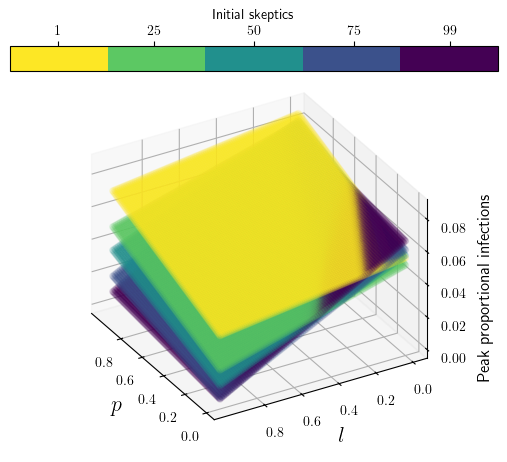

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

init_slice = [0,24,49,74,-1] # this gets values with init_skeptics = 1, 25, 50, 75, or 99
cmap = mpl.cm.get_cmap('viridis_r', len(init_slice))

color_dim = zz_init_skeptics[:,:,init_slice]

ax.scatter(xx_p[:,:,init_slice], yy_l[:,:,init_slice], predictions[:,:,init_slice], c=color_dim, cmap=cmap, alpha=0.15)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1,0.2))
ax.set_yticks(np.arange(0,1,0.2))
ax.set_zticks(np.arange(0,0.1,0.02))

# ax.zaxis.set_major_formatter(ScalarFormatter(useOffset=False))

norm = plt.Normalize(-11, 111)
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, ticks=np.unique(color_dim), label='Initial skeptics', orientation='horizontal', shrink=0.8, location='top', pad=0)
# cbar.ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

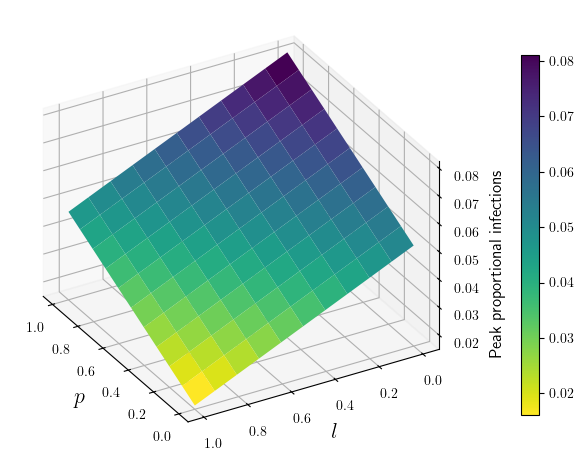

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

init_slice = 29

cmap = plt.get_cmap('viridis_r')

color_dim = predictions[:,:,init_slice]

ax.plot_surface(
    xx_p[:,:,init_slice], 
    yy_l[:,:,init_slice],
    color_dim,
    cmap=cmap,
    rstride=10, cstride=10
)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
# ax.set_zticks(np.arange(0,0.1,0.02))

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

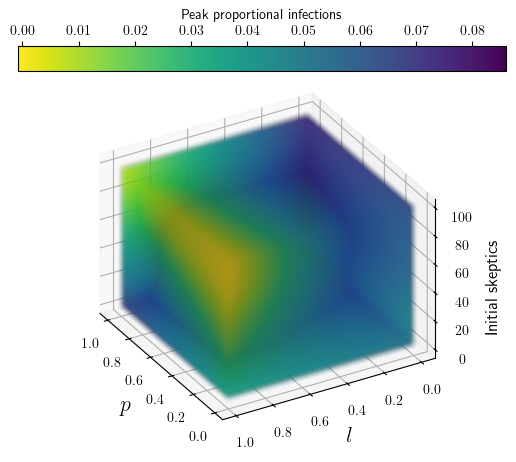

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

color_dim = predictions

ax.scatter(xx_p, yy_l, zz_init_skeptics, c=color_dim, cmap=cmap, alpha=0.01)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Initial skeptics', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_zticks(np.arange(0,101,20))

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0, label='Peak proportional infections', orientation='horizontal', location='top')

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

In [16]:
def group_mean(x,y):
    df = pd.DataFrame(np.stack((x.ravel(),y.ravel()), axis=1)).groupby(0).mean()
    return df.index.to_numpy(), df[1].to_numpy() 

def group_std(x,y):
    df = pd.DataFrame(np.stack((x.ravel(),y.ravel()), axis=1)).groupby(0).std()
    return df.index.to_numpy(), df[1].to_numpy() 

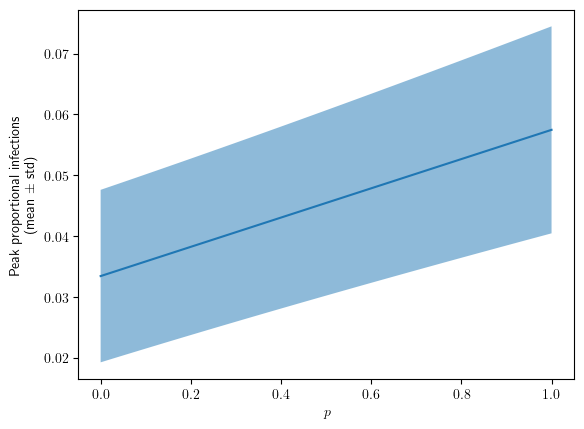

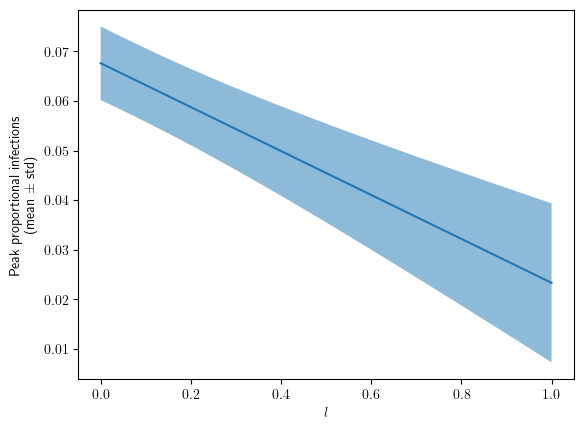

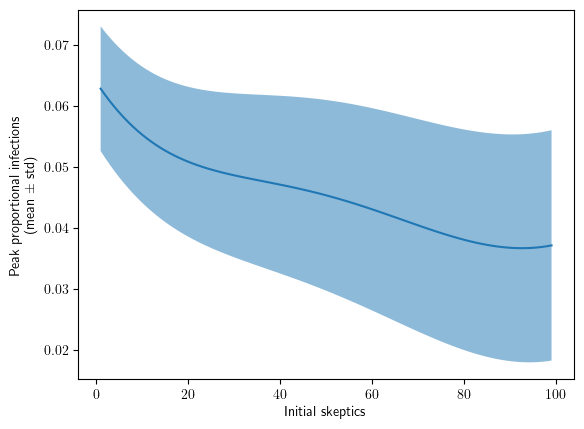

In [17]:
p_mean_idx, p_pred_mean = group_mean(xx_p, predictions)
p_std_idx, p_pred_std = group_std(xx_p, predictions)
# plt.scatter(xx_p.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(p_mean_idx, p_pred_mean)
plt.fill_between(p_std_idx, p_pred_mean+p_pred_std, p_pred_mean-p_pred_std, alpha=0.5)
plt.xlabel('$p$')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

l_mean_idx, l_pred_mean = group_mean(yy_l, predictions)
l_std_idx, l_pred_std = group_std(yy_l, predictions)
# plt.scatter(yy_l.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(l_mean_idx, l_pred_mean)
plt.fill_between(l_std_idx, l_pred_mean+l_pred_std, l_pred_mean-l_pred_std, alpha=0.5)
plt.xlabel('$l$')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

z_mean_idx, z_pred_mean = group_mean(zz_init_skeptics, predictions)
z_std_idx, z_pred_std = group_std(zz_init_skeptics, predictions)
# plt.scatter(zz_init_skeptics.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(z_mean_idx, z_pred_mean)
plt.fill_between(z_std_idx, z_pred_mean+z_pred_std, z_pred_mean-z_pred_std, alpha=0.5)
plt.xlabel('Initial skeptics')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

In [63]:
df = pd.DataFrame({'p': xx_p.ravel(), 'l': yy_l.ravel(), 'init_skeptics': zz_init_skeptics.ravel(), 'prediction': predictions.ravel()})

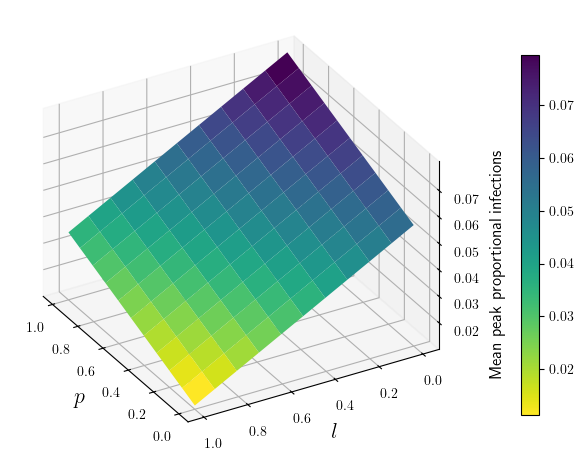

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

grouping = df.groupby(['p','l']).mean()['prediction'].reset_index()

ax.plot_surface(
    np.reshape(grouping['p'], (xx_p.shape[0], yy_l.shape[1])), 
    np.reshape(grouping['l'], (xx_p.shape[0], yy_l.shape[1])),
    np.reshape(grouping['prediction'], (xx_p.shape[0], yy_l.shape[1])),
    cmap=cmap,
    rstride=10, cstride=10
)

color_dim = grouping['prediction']

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Mean peak proportional infections', fontsize=12)

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

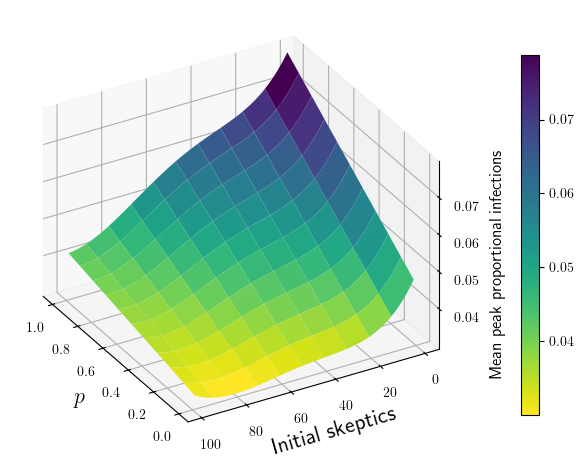

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

grouping = df.groupby(['p','init_skeptics']).mean()['prediction'].reset_index()

ax.plot_surface(
    np.reshape(grouping['p'], (xx_p.shape[0], zz_init_skeptics.shape[2])), 
    np.reshape(grouping['init_skeptics'], (xx_p.shape[0], zz_init_skeptics.shape[2])),
    np.reshape(grouping['prediction'], (xx_p.shape[0], zz_init_skeptics.shape[2])),
    cmap=cmap,
    rstride=10, cstride=10
)

color_dim = grouping['prediction']

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('Initial skeptics', fontsize=16)
ax.set_zlabel('Mean peak proportional infections', fontsize=12)


norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

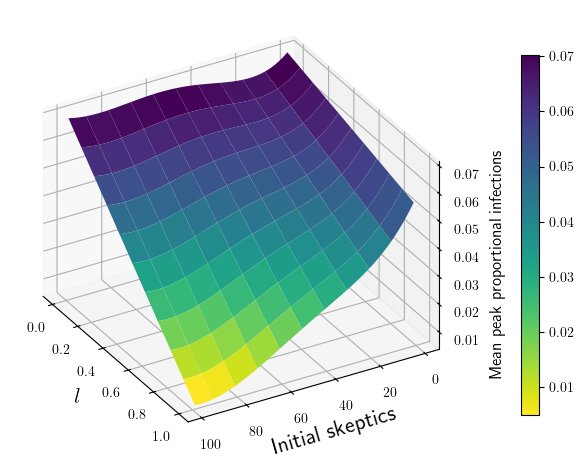

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

grouping = df.groupby(['l','init_skeptics']).mean()['prediction'].reset_index()

ax.plot_surface(
    np.reshape(grouping['l'], (yy_l.shape[1], zz_init_skeptics.shape[2])), 
    np.reshape(grouping['init_skeptics'], (yy_l.shape[1], zz_init_skeptics.shape[2])),
    np.reshape(grouping['prediction'], (yy_l.shape[1], zz_init_skeptics.shape[2])),
    cmap=cmap,
    rstride=10, cstride=10
)

color_dim = grouping['prediction']

ax.set_xlabel('$l$', fontsize=16)
ax.set_ylabel('Initial skeptics', fontsize=16)
ax.set_zlabel('Mean peak proportional infections', fontsize=12)

ax.invert_xaxis()

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()